In [1]:
# HDBscan walkthrough. Test clustering on random moon/blob points

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data

%matplotlib inline
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

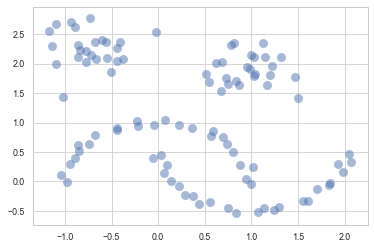

In [2]:
# Generate test data points
moons, _ = data.make_moons(n_samples=50, noise= .05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

In [3]:
# Create HDBscan clusterer
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

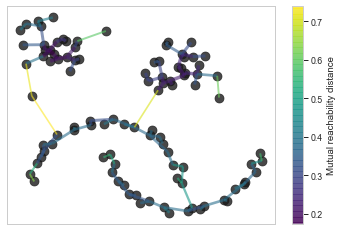

In [4]:
# Create MST
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=1.6)

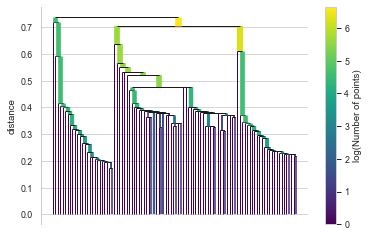

In [5]:
# Create cluster hierarchy
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

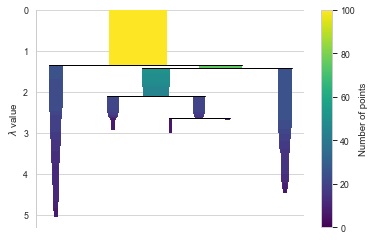

In [6]:
# Condense cluster tree
clusterer.condensed_tree_.plot()

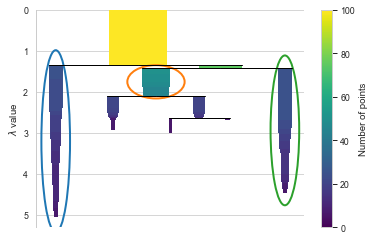

In [7]:
# Identify clusters
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

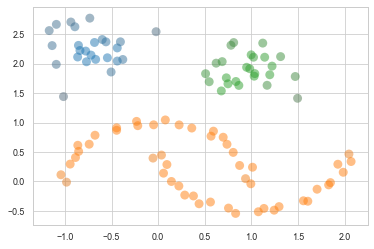

In [8]:
# Highlight clusters by color

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

In [9]:
# Train Word2Vec on Amazon reviews dataset

import os
import csv
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string


csv_path = '/Users/edison/Downloads/amazon-fine-food-reviews'

# Traverse directory and return list of files
def list_files(path):
    r = []
    for root, dirs, files in os.walk(path):
        for name in files:
            r.append(os.path.join(root, name))
    return r

#Parse CSV into list of sentences
def parse_into_list():
    output_list = []
    stops = set(stopwords.words("english"))
    porter = PorterStemmer()
    fields = [] 
    rows = [] 
    for filename in list_files(csv_path):
        with open(filename, 'r') as f:
            try:
                csvreader = csv.reader(f) 
                for row in csvreader:
                    text = row[9]
                    for sentence in text.split('.'):
                        word_list = sentence.split(" ")
                        # Remove stop words & punctuation
                        filtered_words = [word.lower() for word in word_list if word.lower().isalpha() not in stops]
                        # Stem words
                        stemmed = [porter.stem(word) for word in filtered_words]
                        output_list.append(stemmed)
            except(IOError, SyntaxError, ValueError) as e:
                continue
    return output_list

tokens = parse_into_list()
print(tokens[:10])

[['text'], ['i', 'have', 'bought', 'sever', 'of', 'the', 'vital', 'can', 'dog', 'food', 'product', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'qualiti'], ['', 'the', 'product', 'look', 'more', 'like', 'a', 'stew', 'than', 'a', 'process', 'meat', 'and', 'it', 'smell', 'better'], ['', 'my', 'labrador', 'is', 'finicki', 'and', 'she', 'appreci', 'thi', 'product', 'better', 'than', '', 'most'], [''], ['product', 'arriv', 'label', 'as', 'jumbo', 'salt', 'peanut'], [''], [''], ['the', 'peanut', 'were', 'actual', 'small', 'size', 'unsalt'], ['', 'not', 'sure', 'if', 'thi', 'wa', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intend', 'to', 'repres', 'the', 'product', 'as', '"jumbo"']]


In [10]:
# Remove words that appear less than min_occurances times
from collections import Counter 

min_occurances = 5
counter = Counter()

for sentence in tokens:
    for word in sentence:
        counter[word] += 1
        
for sentence in tokens:
    for word in sentence:
        if counter[word] < min_occurances:
            sentence.remove(word)

print(tokens[:10])

[['text'], ['i', 'have', 'bought', 'sever', 'of', 'the', 'vital', 'can', 'dog', 'food', 'product', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'qualiti'], ['', 'the', 'product', 'look', 'more', 'like', 'a', 'stew', 'than', 'a', 'process', 'meat', 'and', 'it', 'smell', 'better'], ['', 'my', 'is', 'finicki', 'and', 'she', 'appreci', 'thi', 'product', 'better', 'than', '', 'most'], [''], ['product', 'arriv', 'label', 'as', 'jumbo', 'salt', 'peanut'], [''], [''], ['the', 'peanut', 'were', 'actual', 'small', 'size', 'unsalt'], ['', 'not', 'sure', 'if', 'thi', 'wa', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intend', 'to', 'repres', 'the', 'product', 'as']]


In [11]:
# Train Gensim Word2Vec model

from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
sentences = []

path = get_tmpfile("word2vec.model")
model = Word2Vec(tokens, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [12]:
# Can save/load model to train later
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)

(1, 2)

In [13]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


['text', 'i', 'have', 'bought', 'sever', 'of', 'the', 'vital', 'can', 'dog', 'food', 'product', 'and', 'found', 'them', 'all', 'to', 'be', 'good', 'qualiti', '', 'look', 'more', 'like', 'a', 'stew', 'than', 'process', 'meat', 'it', 'smell', 'better', 'my', 'is', 'finicki', 'she', 'appreci', 'thi', 'most', 'arriv', 'label', 'as', 'jumbo', 'salt', 'peanut', 'were', 'actual', 'small', 'size', 'unsalt', 'not', 'sure', 'if', 'wa', 'an', 'error', 'or', 'vendor', 'intend', 'repres', 'confect', 'that', 'ha', 'been', 'around', 'few', 'light,', 'citru', 'gelatin', 'with', 'nut', '-', 'in', 'case', 'cut', 'into', 'tini', 'squar', 'then', 'liber', 'coat', 'powder', 'sugar', 'mouth', 'heaven', 'too', 'chewy,', 'veri', 'flavor', 'highli', 'recommend', 'yummi', 'treat', 'you', 'are', 'familiar', 'stori', 'c', 's', '"the']


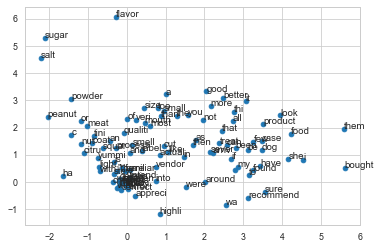

In [14]:
# create a scatter plot of the projection

num_samples = 100

result = result[:num_samples]
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)[:num_samples]
print(words)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [15]:
import hdbscan
import seaborn as sns
import sklearn.datasets as data
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(result)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

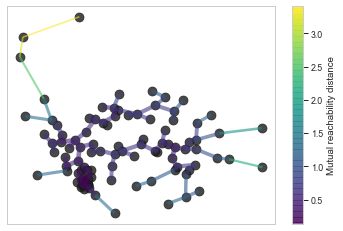

In [16]:
# Create MST
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=1.6)

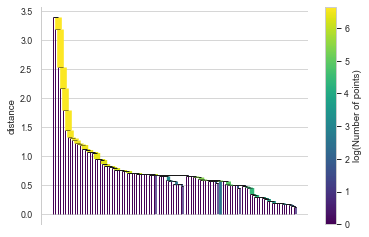

In [17]:
# Create cluster hierarchy
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

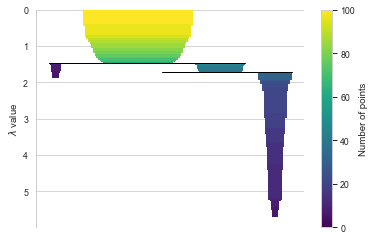

In [18]:
# Condense cluster tree
clusterer.condensed_tree_.plot()

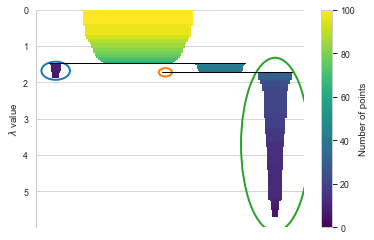

In [19]:
# Highlight clusters
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

<IPython.core.display.Javascript object>


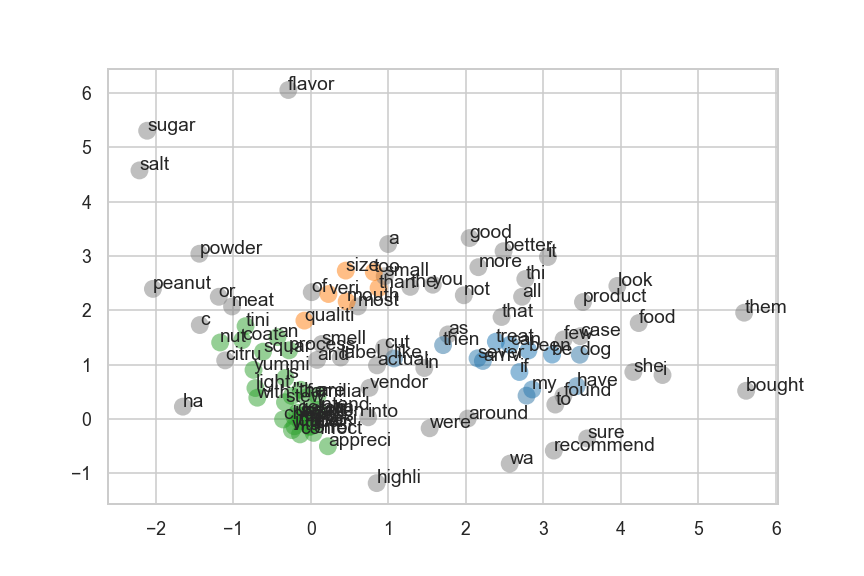

In [22]:
# Group clusters by color
%matplotlib notebook

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(result.T[0], result.T[1], c=cluster_colors, **plot_kwds)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()